# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import igraph as ig 
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
from IPython.display import clear_output

In [2]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"

prime_map = pd.read_csv(data_interim +"mondo_cui_map.csv")
disgenet_map = pd.read_csv(data_external + "disease_mappings.tsv", sep="\t")

disgenet_attr = pd.read_csv(data_external + "disease_mappings_to_attributes.tsv", sep="\t")

prime_nodes = pd.read_csv(data_external+"primekg_nodes.csv")
prime_features = pd.read_csv(data_external +"primekg_disease_features.csv")
prime_grouped = pd.read_csv(data_external + "kg_grouped_diseases.csv")
prime_grouped_bert = pd.read_csv(data_external + "kg_grouped_diseases_bert_map.csv")

In [3]:
#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

# Armo los dataframes

In [4]:
disgenet_map_mondo = disgenet_map[disgenet_map.vocabulary == "MONDO"].astype({"code":"int32"}).reset_index(drop=True)
prime_nodes_diseases = prime_nodes[prime_nodes.node_source == "MONDO"].astype({"node_id":"int32"})
prime_nodes_grouped = prime_nodes[prime_nodes.node_source == "MONDO_grouped"]
print(f"Grupos Bert: {len(prime_grouped_bert.group_id_bert.unique())}")

Grupos Bert: 1267


In [5]:
disgenet_map_mondo

,diseaseId,name,vocabulary,code,vocabularyName
0,C0022661,"Kidney Failure, Chronic",MONDO,1,disease or disorder
1,C0405580,Adrenal cortical hypofunction,MONDO,4,adrenocortical insufficiency
2,C0001623,Adrenal gland hypofunction,MONDO,4,adrenocortical insufficiency
3,C1859877,Alopecia universalis congenita,MONDO,5,"alopecia, isolated"
4,C0005129,Bernard-Soulier Syndrome,MONDO,9,"inherited bleeding disorder, platelet-type"
...,...,...,...,...,...
18507,C0002792,anaphylaxis,MONDO,100053,anaphylaxis
18508,C0413235,Idiopathic anaphylaxis,MONDO,100054,idiopathic anaphylaxis
18509,C0851578,Sleep Disorders,MONDO,100081,sleep disorder
18510,C0175704,LEOPARD Syndrome,MONDO,100082,LEOPARD syndrome 1


In [361]:
dgn_to_prime = pd.merge(disgenet_map_mondo,prime_nodes_diseases,left_on="code",right_on="node_id",how="left",validate="many_to_one").dropna()
mondo_left_out = set(disgenet_map_mondo.diseaseId.values) - set(dgn_to_prime.diseaseId.values)

dgn_to_bert = pd.merge(disgenet_map_mondo,prime_grouped_bert,left_on="code",right_on="node_id",how="left").dropna()
bert_left_out = set(disgenet_map_mondo.diseaseId.values) - set(dgn_to_bert.diseaseId.values)

temp_df = prime_nodes.loc[prime_nodes.node_source == "MONDO_grouped",["node_index","node_id"]].rename(columns={"node_id":"group_id_bert"})
dgn_to_bert = dgn_to_bert.merge(temp_df, on="group_id_bert",how="left").set_index(dgn_to_bert.index)

both_left_out = mondo_left_out&bert_left_out

merged = pd.concat([dgn_to_bert,dgn_to_prime]).sort_index().astype({"node_index":"int"})
merged = merged.drop(columns=["vocabulary","node_id","node_type","node_name","node_source"])
print(f"Filas sin mapear (no corresponden a ningún nodo de prime) {len(both_left_out)}")

Filas sin mapear (no corresponden a ningún nodo de prime) 88


In [7]:
merged

,diseaseId,name,code,vocabularyName,group_name_auto,group_name_bert,group_id_bert,node_index
0,C0022661,"Kidney Failure, Chronic",1,disease or disorder,NaN,NaN,NaN,35856
1,C0405580,Adrenal cortical hypofunction,4,adrenocortical insufficiency,NaN,NaN,NaN,38666
2,C0001623,Adrenal gland hypofunction,4,adrenocortical insufficiency,NaN,NaN,NaN,38666
3,C1859877,Alopecia universalis congenita,5,"alopecia, isolated",NaN,NaN,NaN,38135
4,C0005129,Bernard-Soulier Syndrome,9,"inherited bleeding disorder, platelet-type",NaN,NaN,NaN,38429
...,...,...,...,...,...,...,...,...
18507,C0002792,anaphylaxis,100053,anaphylaxis,NaN,NaN,NaN,39868
18508,C0413235,Idiopathic anaphylaxis,100054,idiopathic anaphylaxis,NaN,NaN,NaN,99978
18509,C0851578,Sleep Disorders,100081,sleep disorder,sleep disorder,anxiety disorder,8187_2050_5618_5451_5371_100081_5383_1942_1098...,27933
18510,C0175704,LEOPARD Syndrome,100082,LEOPARD syndrome 1,LEOPARD syndrome,LEOPARD syndrome,13380_12691_100082,29477


Quienes no pude matchear?

In [15]:
disgenet_map_mondo.loc[list(both_left_out)]

,diseaseId,name,vocabulary,code,vocabularyName
13827,C4310671,"ENCEPHALOPATHY, PROGRESSIVE, EARLY-ONSET, WITH...",MONDO,14964,"encephalopathy, progressive, early-onset, with..."
12,C0015306,Hereditary Multiple Exostoses,MONDO,24,"exostoses, multiple"
5133,C0403445,Fechtner syndrome (disorder),MONDO,7954,May-Hegglin anomaly
5134,C1842035,Giant Platelet Syndrome with Thrombocytopenia,MONDO,7954,May-Hegglin anomaly
5135,C1854520,SEBASTIAN SYNDROME,MONDO,7954,May-Hegglin anomaly
...,...,...,...,...,...
16886,C0949658,"Cardiomyopathy, Hypertrophic, Familial",MONDO,20484,rare familial disorder with hypertrophic cardi...
8185,C2936419,"46, XX Testicular Disorders of Sex Development",MONDO,10766,"46,XX testicular disorder of sex development"
8186,C0432475,XX males,MONDO,10766,"46,XX testicular disorder of sex development"
8187,C2748895,Ovotesticular Disorders of Sex Development,MONDO,10766,"46,XX testicular disorder of sex development"


# Exploro como quedó el mapeo

Se que el mapeo es many to one, necesito resolver esos conflictos para poder mapearlo a mi red.

In [17]:
merged[merged.diseaseId.duplicated(keep=False)].sort_values(by="diseaseId")

,diseaseId,name,code,vocabularyName,group_name_auto,group_name_bert,group_id_bert,node_index
18007,C0000889,Acanthosis Nigricans,43003,familial acanthosis nigricans,NaN,NaN,NaN,31101
4063,C0000889,Acanthosis Nigricans,7035,acanthosis nigricans (disease),NaN,NaN,NaN,38504
4936,C0001080,Achondroplasia,7793,hypochondroplasia,NaN,NaN,NaN,27228
4064,C0001080,Achondroplasia,7037,achondroplasia,NaN,NaN,NaN,28484
17565,C0001125,"Acidosis, Lactic",24306,acquired lactic acidosis,NaN,NaN,NaN,83895
...,...,...,...,...,...,...,...,...
10984,C4755264,Severe intellectual disability and progressive...,13048,hereditary spastic paraplegia 50,hereditary spastic paraplegia,hereditary spastic paraplegia,14302_12928_14568_12867_12766_13132_13239_1148...,27630
13194,C4757950,Isolated ATP synthase deficiency,14471,mitochondrial proton-transporting ATP synthase...,NaN,NaN,NaN,38917
12555,C4757950,Isolated ATP synthase deficiency,14091,mitochondrial complex V (ATP synthase) deficie...,mitochondrial complex V (ATP synthase) deficie...,mitochondrial complex V (ATP synthase) deficie...,11421_14091_13546_13547,29885
11706,C4757950,Isolated ATP synthase deficiency,13547,mitochondrial complex V (ATP synthase) deficie...,mitochondrial complex V (ATP synthase) deficie...,mitochondrial complex V (ATP synthase) deficie...,11421_14091_13546_13547,29885


## Idea: agrego nodos BERT a la red que funcionen como hubs

Para ver que tanta información perdería unificando nodos, veo cuantos id únicos hay en cada ontología:

In [19]:
cui_unicos = len(merged.diseaseId.unique())
mondo_unicos = len(merged.code.unique())

print(f"CUI únicos: {cui_unicos}\nMONDO únicos: {mondo_unicos}")
print(f"Unificar en mondo implica una reducción del {100 - round((mondo_unicos*100)/cui_unicos)}%")

CUI únicos: 13203
MONDO únicos: 12184
Unificar en mondo implica una reducción del 8%


In [22]:
disease_id = merged[merged.diseaseId.duplicated(keep=False)].sample(1).diseaseId.values[0]
conflict = merged[merged.diseaseId == disease_id]
mondos = conflict.code.values
available_mondos = [mondo for mondo in mondos if mondo in prime_map.mondo.values]

if len(available_mondos) == 0:
    print(f"No mondo ids found in prime map")
else:
    prime_says = prime_map.set_index("mondo").loc[available_mondos]
    solve = pd.merge(conflict,prime_says, left_on="code",right_on="mondo")
    solved = solve[solve.diseaseId == solve.CUI]
    print(f"El CUI {disease_id} corresponde a más de un MONDO")
    display(conflict)

    print(f"\nSegún el mapeo de prime estos MONDOS corresponden a estos CUI:")
    display(prime_says)

    print(f"\nTrato de matchearlo con mi tabla")
    display(solve)

    print(f"\nMe quedo con el que coindiden los dos mapas (diseaseID == CUI)")
    display(solved)

El CUI C0016522 corresponde a más de un MONDO


,diseaseId,name,code,vocabularyName,group_name_auto,group_name_bert,group_id_bert,node_index
4233,C0016522,"Foramen Ovale, Patent",7172,atrial heart septal defect 1,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295
4241,C0016522,"Foramen Ovale, Patent",7173,atrial heart septal defect 7,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295
9670,C0016522,"Foramen Ovale, Patent",11938,atrial heart septal defect 2,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295
10478,C0016522,"Foramen Ovale, Patent",12654,atrial heart septal defect 4,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295
10940,C0016522,"Foramen Ovale, Patent",13011,atrial heart septal defect 5,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295
11062,C0016522,"Foramen Ovale, Patent",13123,atrial heart septal defect 6,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295
11732,C0016522,"Foramen Ovale, Patent",13567,atrial heart septal defect 3,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295
11964,C0016522,"Foramen Ovale, Patent",13750,atrial heart septal defect 8,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295
12029,C0016522,"Foramen Ovale, Patent",13770,atrial heart septal defect 9,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295
16870,C0016522,"Foramen Ovale, Patent",20439,patent foramen ovale (disease),NaN,NaN,NaN,94563



Según el mapeo de prime estos MONDOS corresponden a estos CUI:


,CUI
mondo,
7172,C1862389
7173,C3502353
11938,C1842778
12654,C1969657
13011,C2748552
13123,C2751315
13567,C3279790
13770,C3280943
20439,C0016522



Trato de matchearlo con mi tabla


,diseaseId,name,code,vocabularyName,group_name_auto,group_name_bert,group_id_bert,node_index,CUI
0,C0016522,"Foramen Ovale, Patent",7172,atrial heart septal defect 1,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295,C1862389
1,C0016522,"Foramen Ovale, Patent",7173,atrial heart septal defect 7,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295,C3502353
2,C0016522,"Foramen Ovale, Patent",11938,atrial heart septal defect 2,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295,C1842778
3,C0016522,"Foramen Ovale, Patent",12654,atrial heart septal defect 4,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295,C1969657
4,C0016522,"Foramen Ovale, Patent",13011,atrial heart septal defect 5,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295,C2748552
5,C0016522,"Foramen Ovale, Patent",13123,atrial heart septal defect 6,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295,C2751315
6,C0016522,"Foramen Ovale, Patent",13567,atrial heart septal defect 3,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295,C3279790
7,C0016522,"Foramen Ovale, Patent",13770,atrial heart septal defect 9,atrial septal defect,atrial septal defect,7172_13750_13770_12654_13123_11938_13011_7173_...,28295,C3280943
8,C0016522,"Foramen Ovale, Patent",20439,patent foramen ovale (disease),NaN,NaN,NaN,94563,C0016522



Me quedo con el que coindiden los dos mapas (diseaseID == CUI)


,diseaseId,name,code,vocabularyName,group_name_auto,group_name_bert,group_id_bert,node_index,CUI
8,C0016522,"Foramen Ovale, Patent",20439,patent foramen ovale (disease),NaN,NaN,NaN,94563,C0016522


# Resuelvo conflictos de mapeo

In [14]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
custom_stopwords = ["disease","syndrome","disorder","type","association","abnormality"]
stop_words = text.ENGLISH_STOP_WORDS.union(custom_stopwords)
import nltk
from nltk.stem import WordNetLemmatizer

def remove_symbols(data):
    symbols = "!-\"\'#$%&()*+/:;<=>?@[\]^_`{|},~\n"
    for i in symbols:
        data = np.char.replace(data, i, ' ')
    return data

def get_tfidf_df(vectorizer,corpus,ids,df=True):
    X = vectorizer.fit_transform(corpus)
    if df:
        #X = pd.DataFrame(X.toarray(), index=ids, columns=vectorizer.get_feature_names_out())
        X = pd.DataFrame.sparse.from_spmatrix(X, index=ids, columns=vectorizer.get_feature_names_out())
    return X

def tfidf_similarity(vectorizer,corpus1,corpus2,ids1,ids2,df=True):
    full_corpus = np.concatenate([corpus1,corpus2])
    full_ids = np.concatenate([ids1,ids2])
    scores = get_tfidf_df(vectorizer,full_corpus,full_ids,False)
    similarity_matrix = cosine_similarity(scores,scores,False)
    if df:
        similarity_matrix = pd.DataFrame.sparse.from_spmatrix(similarity_matrix, index=full_ids, columns=full_ids)
    return similarity_matrix

lemmatizer = WordNetLemmatizer()
def filter_plurals(lemmatizer, text):
    words = text.split()
    new_text = ""
    for word in words :
        lem = lemmatizer.lemmatize(word)
        new_text += " " + lem
    return new_text

def preprocess(corpus,lemma_filter=False):
    corpus = np.char.lower(corpus)
    corpus = remove_symbols(corpus)
    if lemma_filter:
        corpus = np.array([filter_plurals(lemmatizer,text) for text in corpus]).astype(str)
    return corpus

In [165]:
def map_matching(merged,prime_map,disease_id,quiet=True):
    conflict_solved = False
    conflict = merged[merged.diseaseId == disease_id]
    mondos = conflict.code.values
    available_mondos = [mondo for mondo in mondos if mondo in prime_map.mondo.values]
    match_row = []

    if len(available_mondos) == 0:
        if not quiet:
            print(f"No mondo ids found in prime map")
    else:
        prime_says = prime_map.set_index("mondo").loc[available_mondos]
        solve = pd.merge(conflict,prime_says, left_on="code",right_on="mondo")
        solved = solve[solve.diseaseId == solve.CUI]
        if len(solved) == 1:
            conflict_solved = True
            match_row = solved.drop(columns="CUI")
            if not quiet:
                print("Conflict solved by map matching!")
                display(solved)
        else:
            if not quiet:
                print("Could not solve conflict by map matching")
    return (conflict_solved, match_row)

def similarity_matching(merged,disease_id,similarity_matrix,corpus,ids,quiet=True):
    conflict_solved = False
    true_name = merged.set_index("diseaseId").loc[disease_id,"name"].unique()
    top_match = similarity_matrix[disease_id].idxmax()
    top_match_score = similarity_matrix[disease_id].max()
    match_row = []
    if top_match_score > 0.5:
        match_row = merged[(merged.diseaseId == disease_id) & (merged.code == top_match)]
        if len(match_row) == 0:
            match_row = [disease_id,top_match]
        if not quiet:
            print("Conflict solved by semantic similarity between all pairs!")
            print(corpus[ids == top_match])
    else:
        if not quiet:
            print("Low score")
            print(f"name: {true_name}, top match name: {corpus[ids == top_match]}, score: {round(top_match_score,2)}")
    return (conflict_solved, match_row)

def similarity_matching_candidates(merged,disease_id,similarity_matrix,corpus,ids,quiet=True):
    conflict_solved = False
    true_name = merged.set_index("diseaseId").loc[disease_id,"name"].unique()
    
    candidates = np.concatenate([merged.set_index("diseaseId").loc[disease_id,"code"].dropna().values, merged.set_index("diseaseId").loc[disease_id,"group_id_bert"].dropna().values])
    candidates = [candidate for candidate in candidates if candidate in ids]

    top_match_score = similarity_matrix[disease_id].loc[candidates].max()
    top_match = similarity_matrix[disease_id].loc[candidates].idxmax()
    match_row = []
    if top_match_score > 0.5:
        conflict_solved = True
        match_row = merged[((merged.diseaseId == disease_id) & (merged.code == top_match) ) | ((merged.diseaseId == disease_id) & (merged.group_id_bert == top_match))]
        if not quiet:
            print("Conflict solved by semantic similarity between candidates!")
            print(corpus[ids == top_match])
    else:
        if not quiet:
            print("Low score")
            print(f"name: {true_name}, top match name: {corpus[ids == top_match]}, score: {round(top_match_score,2)}")
    return (conflict_solved, match_row)


def negative_cases(merged,disease_id,cui_corpus,cui_ids,quiet):
    negative_case = False
    tokenized_name = cui_corpus[cui_ids == disease_id][0].split()
    if "non" in tokenized_name:
        negative_case = True
        if not quiet:
            print(f"Negative case detected, lower confidence in tfidf score, giving suggestions")
    return negative_case

def same_group(merged,disease_id,bert_set,quiet):
    conflict_solved = False
    match_row = []
    if disease_id in bert_set:
        unique_bert = merged.set_index("diseaseId").loc[disease_id,"group_id_bert"].unique()
        if len(unique_bert) == 1:
            match_row = merged[(merged.diseaseId == disease_id) & (merged.group_id_bert == unique_bert[0])].drop_duplicates(subset=["name","group_id_bert"])
            conflict_solved = True
            if not quiet:
                print("Id matches to same Bert Group, solved!")
    return (conflict_solved, match_row)

def conflict_solver(merged,disease_id,prime_map,right_corpus,right_ids,similarity_matrix,cui_corpus,cui_ids,bert_set,quiet=True):
    conflict_solved,row = map_matching(merged,prime_map,disease_id,quiet)
    if not conflict_solved:
        conflict_solved,row = same_group(merged,disease_id,bert_set,quiet)
        if not conflict_solved:
            negative_case = negative_cases(merged,disease_id,cui_corpus,cui_ids,quiet)
            conflict_solved, row = similarity_matching_candidates(merged,disease_id,similarity_matrix,right_corpus,right_ids,quiet)
            if not conflict_solved:
                conflict_solved, row = similarity_matching(merged,disease_id,similarity_matrix,right_corpus,right_ids,quiet)
                if negative_case:
                    conflict_solved = False
    return (conflict_solved, row)

Total conflictos D->P: 2430
Total mapeos: 13203 
Porcentaje de mapeos en conflicto D->P: 18.4%


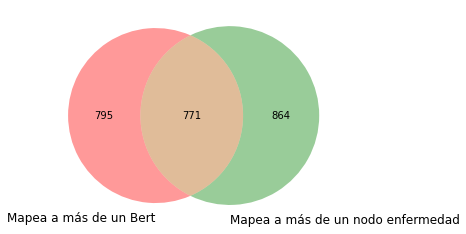

In [28]:
duplicated_bert = merged[merged.diseaseId.duplicated(keep=False) & ~merged.group_id_bert.isna()].sort_values(by="diseaseId")
duplicated_not_bert = merged[merged.diseaseId.duplicated(keep=False) & merged.group_id_bert.isna()].sort_values(by="diseaseId")
duplicated_all = merged[merged.diseaseId.duplicated(keep=False)].sort_values(by="diseaseId")

s1 = set(duplicated_bert.diseaseId.values)
s2 = set(duplicated_not_bert.diseaseId.values)

plt.figure()
v2 = venn2([s1,s2], set_labels = ["Mapea a más de un Bert", "Mapea a más de un nodo enfermedad"])

bert_groups_only = s1-s2
single_disease_only = s2-s1
bert_and_single = s1&s2

print(f"Total conflictos D->P: {len(s1|s2)}\nTotal mapeos: {len(merged.diseaseId.unique())} \nPorcentaje de mapeos en conflicto D->P: {round(len(s1|s2)*100/len(merged.diseaseId.unique()),2)}%")

Armo corpus y matrices de similaridad

In [16]:
corpus_cui = merged.name.drop_duplicates(keep="first").values.astype(str)
corpus_mondo = merged.vocabularyName.drop_duplicates(keep="first").values.astype(str)
corpus_bert = merged.group_name_bert.drop_duplicates(keep="first").values.astype(str)

ids_cui = merged.diseaseId.drop_duplicates(keep="first").values
ids_mondo = merged.code.drop_duplicates(keep="first").values
ids_bert = merged.group_id_bert.drop_duplicates(keep="first").values
ids_bert_mondo = np.concatenate([ids_bert,ids_mondo])

corpus_cui = preprocess(corpus_cui,True)
corpus_mondo = preprocess(corpus_mondo,True)
corpus_bert = preprocess(corpus_bert,True)
corpus_bert_mondo = np.concatenate([corpus_bert,corpus_mondo])


vectorizer = TfidfVectorizer(tokenizer = lambda document: document.split(),stop_words=stop_words, ngram_range=(1,1))
tfidf_similarity_matrix = tfidf_similarity(vectorizer,corpus_cui,corpus_mondo,ids_cui,ids_mondo)
tfidf_similarity_matrix = tfidf_similarity_matrix.loc[ids_mondo,ids_cui]

tfidf_similarity_matrix_bert = tfidf_similarity(vectorizer,corpus_cui,corpus_bert,ids_cui,ids_bert)
tfidf_similarity_matrix_bert = tfidf_similarity_matrix_bert.loc[ids_bert,ids_cui]

tfidf_similarity_matrix_bert_mondo = tfidf_similarity(vectorizer,corpus_cui,corpus_bert_mondo,ids_cui,ids_bert_mondo)
tfidf_similarity_matrix_bert_mondo = tfidf_similarity_matrix_bert_mondo.loc[ids_bert_mondo,ids_cui]

In [29]:
conflictos = {"bert_only":{"set":bert_groups_only, "ids":ids_bert, "matrix":tfidf_similarity_matrix_bert, "corpus": corpus_bert},
                "bert_mixed":{"set":bert_and_single, "ids":ids_bert_mondo, "matrix":tfidf_similarity_matrix_bert_mondo, "corpus":corpus_bert_mondo},
                "not_grouped":{"set":single_disease_only, "ids":ids_mondo, "matrix":tfidf_similarity_matrix, "corpus":corpus_mondo}}

In [166]:
def get_resolved_df(conflict_dict):
    resolve = []
    manual_check = []
    for id in list(conflict_dict["set"]):
        solved, solved_row = conflict_solver(merged,id,prime_map,conflict_dict["corpus"],conflict_dict["ids"],conflict_dict["matrix"],corpus_cui,ids_cui,bert_groups_only,True)
        if solved:
            resolve.append(solved_row)
        elif solved_row:
            manual_check.append(solved_row)
        else:
            manual_check.append([id,-1])

    df = pd.concat(resolve)
    df = df.drop_duplicates(subset=["name","group_id_bert"])
    results = {"df":df, "manual_check":manual_check}
    return results

In [167]:
conflictos_resueltos = {}
for caso,datos in conflictos.items():
    resultados = get_resolved_df(datos)
    conflictos_resueltos[caso] = resultados

In [168]:
total_solved = []
total_unsolved = []
for case, results in conflictos_resueltos.items():
    print(f"{case}:\nResueltos: {len(results['df'])} \nSin resolver: {len(results['manual_check'])}\n")
    total_solved.append(len(results['df']))
    total_unsolved.append(len(results['manual_check']))

print(f"Total solved: {sum(total_solved)}\nUnsolved: {sum(total_unsolved)}")
print(f"Resolví {round(100*sum(total_solved)/len(duplicated_all.diseaseId.unique()))}% de los conflictos")

bert_only:
Resueltos: 755 
Sin resolver: 40

bert_mixed:
Resueltos: 669 
Sin resolver: 102

not_grouped:
Resueltos: 766 
Sin resolver: 98

Total solved: 2190
Unsolved: 240
Resolví 90% de los conflictos


In [169]:
unsolved = [case["manual_check"] for case in conflictos_resueltos.values()]
manual_solved = []
checkpoint = [0,0]

exit = False
for i,case in enumerate(unsolved):
    if exit:
        break
    for j,pair in enumerate(case):
        id = pair[0]
        suggestion = pair[1]
        print(f"Original name: {merged.set_index('diseaseId').loc[id,'name'].unique()}")
        print(f"Suggestion: {suggestion}")
        display(merged.set_index("diseaseId").loc[id])
        display(merged.set_index("code").group_name_bert.get(suggestion))
        display(merged.set_index("group_id_bert").group_name_bert.get(suggestion))
        manual_input = input("Enter best id match")
        if manual_input == "":
            checkpoint = [i,j]
            exit = True
            break
        else:  
            manual_solved.append([id,manual_input])
            clear_output(wait=True)

print(f"Last input at {checkpoint}")
solved_array = np.array(manual_solved)

Last input at [0, 0]


In [335]:
#typo_ids = manual_maps[manual_maps.node_index.isna()].diseaseId.values
#merged.set_index("diseaseId").loc[typo_ids]
typos = {"C1868683":4948,"C1856797":9215,"C0154671":22687,"C0085786":2429}

for cui,mondo in typos.items():
    solved_array[np.where(solved_array[:,0] == cui),1] = mondo

In [340]:
manual_maps = pd.DataFrame({"diseaseId":solved_array[:,0],"code":solved_array[:,1]})
manual_berts = manual_maps[manual_maps.code.apply(lambda x: "_" in str(x))].rename(columns={"code":"group_id_bert"})
# manual_berts = pd.merge(manual_berts, merged[["group_id_bert","group_name_auto","group_name_bert","node_index"]], left_on="group_id_bert",right_on="group_id_bert").drop_duplicates(subset="node_index")

manual_maps = pd.merge(manual_maps,manual_berts, left_on="diseaseId",right_on="diseaseId",how="left")
manual_maps.code = manual_maps.code.apply(lambda x: str(x).split("_")[0])
manual_maps = manual_maps.astype({"code":"int"})
manual_maps = pd.merge(manual_maps,disgenet_map_mondo[["diseaseId","name"]], left_on="diseaseId",right_on="diseaseId", how="left").drop_duplicates()
manual_maps = pd.merge(manual_maps,disgenet_map_mondo[["code","vocabularyName"]], left_on="code",right_on="code",how="left").drop_duplicates()
manual_maps = pd.merge(manual_maps,merged[["code","node_index","group_name_auto","group_name_bert"]], left_on="code",right_on="code",how="left").drop_duplicates()


manual_maps = pd.merge(manual_maps[["diseaseId","code","name","node_index"]], prime_grouped_bert[["node_id","group_id_bert","group_name_bert","group_name_auto"]],left_on="code",right_on="node_id",how="left")
#manual_maps.to_csv(data_interim+"manual_disease_maps.csv")

In [347]:
all_solved_conflicts = pd.concat([conflictos_resueltos["bert_only"]["df"], conflictos_resueltos["bert_mixed"]["df"],conflictos_resueltos["not_grouped"]["df"],manual_maps])

In [348]:
all_solved_conflicts

,diseaseId,name,code,vocabularyName,group_name_auto,group_name_bert,group_id_bert,node_index
2,C0272199,Familial Hemophagocytic Lymphocytosis,9974,familial hemophagocytic lymphohistiocytosis ty...,familial hemophagocytic lymphohistiocytosis,hemophagocytic lymphohistiocytosis,11337_11336_13135_9974_12146_15541_15542_33557,29161
1,C0022584,"Keratoderma, Palmoplantar, Diffuse",17666,diffuse palmoplantar keratoderma,diffuse palmoplantar keratoderma,diffuse palmoplantar keratoderma,17666_17670_20093_20096_18250,38136
6319,C0266568,Persistent Hyperplastic Primary Vitreous,9097,"persistent hyperplastic primary vitreous, auto...","persistent hyperplastic primary vitreous, auto...",persistent hyperplastic primary vitreous,9097_19631_12653,31357
1,C1631597,"VENTRICULAR TACHYCARDIA, CATECHOLAMINERGIC POL...",17990,catecholaminergic polymorphic ventricular tach...,catecholaminergic polymorphic ventricular tach...,catecholaminergic polymorphic ventricular tach...,14191_12762_11484_13966_13529_17990,27503
6300,C4551509,Jervell And Lange-Nielsen Syndrome 1,9078,Jervell and Lange-Nielsen syndrome,Jervell and Lange-Nielsen syndrome,Jervell and Lange-Nielsen syndrome,24540_12871_9078,28812
...,...,...,...,...,...,...,...,...
801,C0334492,Malignant mesenchymal tumor,3633,malignant mesenchymoma,NaN,NaN,NaN,37185
802,C0037999,Splenic Neoplasms,36696,spleen neoplasm,NaN,NaN,NaN,37880
803,C1866559,"Spina Bifida, Folate-Sensitive",11120,"neural tube defects, folate-sensitive",NaN,NaN,NaN,28904
805,C1406717,Sirenomelia syndrome,8800,microphthalmia with limb anomalies,NaN,NaN,NaN,27616


In [356]:
not_duplicated = merged[~merged.diseaseId.duplicated(keep=False)].sort_values(by="diseaseId")
final = pd.concat([not_duplicated,all_solved_conflicts])
#final.to_csv(data_interim+"disease_vocab_mapping.csv", index=False)

In [395]:
final

,diseaseId,name,code,vocabularyName,group_name_auto,group_name_bert,group_id_bert,node_index
5832,C0000744,Abetalipoproteinemia,8692,abetalipoproteinemia,NaN,NaN,NaN,31820
361,C0000768,Congenital Abnormality,839,congenital abnormality,NaN,NaN,NaN,35598
14707,C0000771,"Abnormalities, Drug-Induced",16677,toxic or drug-related embryofetopathy,NaN,NaN,NaN,38626
3877,C0000809,"Abortion, Habitual",6774,habitual spontaneous abortion,NaN,NaN,NaN,95075
2274,C0000821,Threatened abortion,4846,placental abruption (disease),NaN,NaN,NaN,83943
...,...,...,...,...,...,...,...,...
801,C0334492,Malignant mesenchymal tumor,3633,malignant mesenchymoma,NaN,NaN,NaN,37185
802,C0037999,Splenic Neoplasms,36696,spleen neoplasm,NaN,NaN,NaN,37880
803,C1866559,"Spina Bifida, Folate-Sensitive",11120,"neural tube defects, folate-sensitive",NaN,NaN,NaN,28904
805,C1406717,Sirenomelia syndrome,8800,microphthalmia with limb anomalies,NaN,NaN,NaN,27616
